In [1]:
import os
import stat
import numpy as np
import matplotlib.pyplot as plt
import mindspore  # 载入mindspore的默认数据集
import mindspore.nn as nn  # 各类网络层都在nn里面
from mindspore import Tensor  # mindspore的tensor
from mindspore import context  # 设置mindspore运行的环境
import mindspore.dataset as ds  # 常用转化用算子
from mindspore.train import Model  # 引入模型
from mindspore.nn.metrics import Accuracy  # 引入评估模型的包
from mindspore.common import dtype as mstype
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C  # 图像转化用算子
from mindspore.common.initializer import TruncatedNormal  # 参数初始化的方式
from mindspore.dataset.engine.datasets import Cifar10Dataset
from mindspore.train.serialization import load_checkpoint, load_param_into_net, save_checkpoint
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Callback  # 引入训练时候会使用到回调函数，如checkpoint, lossMoniter

In [2]:
accuracy_show = []
loss_show = []
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """weight initial for conv layer"""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")
def fc_with_initialize(input_channels, out_channels):
    """weight initial for fc layer"""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)
def weight_variable():
    """weight initial"""
    return TruncatedNormal(0.02)
class LeNet5_2(nn.Cell):
    """
    Lenet network
    Args:
        num_class (int): Num classes. Default: 10.

    Returns:
        Tensor, output tensor
    Examples:
        >>> LeNet(num_class=10)

    """
    def __init__(self, num_class=10, channel=3):
        super(LeNet5_2, self).__init__()
        self.num_class = num_class
        self.conv1 = conv(channel, 64, 3)
        self.conv2 = conv(64, 128, 3)
        self.conv3 = conv(128, 128, 3)
        self.fc1 = fc_with_initialize(512, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, self.num_class)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [3]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range 
def get_data(datapath):
    cifar_ds = ds.Cifar10Dataset(datapath)
    return cifar_ds
def process_dataset(cifar_ds,batch_size =32,status="train"):
    '''
    ---- 定义算子 ----
    '''
    # 归一化
    rescale = 1.0 / 255.0
    # 平移
    shift = 0.0

    resize_op = CV.Resize((32, 32))
    rescale_op = CV.Rescale(rescale, shift)
    # 对于RGB三通道分别设定mean和std
    normalize_op = CV.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    if status == "train":
        # 随机裁剪
        random_crop_op = CV.RandomCrop([32, 32], [4, 4, 4, 4])
        # 随机翻转
        random_horizontal_op = CV.RandomHorizontalFlip()
    # 通道变化
    channel_swap_op = CV.HWC2CHW()
    # 类型变化
    typecast_op = C.TypeCast(mstype.int32)

    '''
    ---- 算子运算 ----
    '''
    cifar_ds = cifar_ds.map(input_columns="label", operations=typecast_op)
    if status == "train":
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_crop_op)
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_horizontal_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=resize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=rescale_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=normalize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=channel_swap_op)

    # shuffle
    cifar_ds = cifar_ds.shuffle(buffer_size=1000)
    # 切分数据集到batch_size
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)

    return cifar_ds
def filter_checkpoint_parameter_by_list(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break
def apply_eval(eval_param):
    eval_model = eval_param['model']
    eval_ds = eval_param['dataset']
    metrics_name = eval_param['metrics_name']
    res = eval_model.eval(eval_ds)
    return res[metrics_name]
class EvalCallBack(Callback):
    """
    回调类，获取训练过程中模型的信息
    """

    def __init__(self, eval_function, eval_param_dict, a=0, eval_start_epoch=1, interval=1, save_best_ckpt=True,
                 ckpt_directory="./", besk_ckpt_name="best.ckpt", metrics_name="acc"):
        super(EvalCallBack, self).__init__()
        self.eval_param_dict = eval_param_dict
        self.eval_function = eval_function
        self.eval_start_epoch = eval_start_epoch
        if interval < 1:
            raise ValueError("interval should >= 1.")
        self.interval = interval
        self.save_best_ckpt = save_best_ckpt
        self.best_res = 0
        self.best_epoch = 0
        if not os.path.isdir(ckpt_directory):
            os.makedirs(ckpt_directory)
        self.best_ckpt_path = os.path.join(ckpt_directory, besk_ckpt_name)
        self.metrics_name = metrics_name

    # 删除ckpt文件
    def remove_ckpoint_file(self, file_name):
        os.chmod(file_name, stat.S_IWRITE)
        os.remove(file_name)

    # 每一个epoch后，打印训练集的损失值和验证集的模型精度，并保存精度最好的ckpt文件
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        loss_epoch = cb_params.net_outputs
        if cur_epoch >= self.eval_start_epoch and (cur_epoch - self.eval_start_epoch) % self.interval == 0:
            res = self.eval_function(self.eval_param_dict)
            print('Epoch {}/{}'.format(cur_epoch, num_epochs))
            print('-' * 10)
            print('train Loss: {}'.format(loss_epoch))
            print('val Acc: {}'.format(res))
            loss_show.append(format(loss_epoch))
            accuracy_show.append(res)
            if res >= self.best_res:
                self.best_res = res
                self.best_epoch = cur_epoch
                if self.save_best_ckpt:
                    if os.path.exists(self.best_ckpt_path):
                        self.remove_ckpoint_file(self.best_ckpt_path)
                save_checkpoint(cb_params.train_network, self.best_ckpt_path)

    # 训练结束后，打印最好的精度和对应的epoch
    def end(self, run_context):
        print("End training, the best {0} is: {1}, the best {0} epoch is {2}".format(self.metrics_name, self.best_res, self.best_epoch), flush=True)

In [4]:
num_epochs = 50
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
# 创建图像标签列表
class_name = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
train_path='cifar-10-batches-bin'
batch_size=32
status="train"
# 生成训练数据集
train_ds = get_data(train_path)
ds_train = process_dataset(train_ds,batch_size =batch_size, status=status)

test_path = 'test'
batch = 32
status="test"
# 生成测试数据集
test_ds = ds.Cifar10Dataset(test_path)
ds_eval = process_dataset(test_ds, batch_size=batch_size, status=status)

In [5]:
net = LeNet5_2(10)
# 加载预训练模型
param_dict = load_checkpoint('85.ckpt')
# 获取全连接层的名字
filter_list = {'moments.fc3'}
# 删除预训练模型的全连接层
filter_checkpoint_parameter_by_list(param_dict, filter_list)
# 给网络加载参数
load_param_into_net(net,param_dict)
# 使用交叉熵函数作为损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
# 优化器为momentum
net_opt = nn.Momentum(params=net.trainable_params(), learning_rate=0.01, momentum=0.9)
# 时间监控，反馈每个epoch的运行时间
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
# 实例化模型
model = Model(network = net, loss_fn=net_loss,optimizer=net_opt, metrics={"Accuracy": Accuracy()})

Delete parameter from checkpoint:  moments.fc3.weight
Delete parameter from checkpoint:  moments.fc3.bias


In [6]:
# 模型训练
eval_param_dict = {"model":model,"dataset":ds_eval,"metrics_name":"Accuracy"}
eval_cb = EvalCallBack(apply_eval, eval_param_dict,)

# visualize_model('checkpoint_lenet_verified_3-118_1875.ckpt', ds_eval)
print("============== Starting Training ==============")
# 训练模型
model.train(num_epochs, ds_train, callbacks=[eval_cb, TimeMonitor()], dataset_sink_mode=True)

============== Starting Training ==============
Epoch 1/50
----------
train Loss: 0.46174577
val Acc: 0.8325320512820513
epoch time: 9580.770 ms, per step time: 5.110 ms
Epoch 2/50
----------
train Loss: 0.89822674
val Acc: 0.8301282051282052
epoch time: 5486.534 ms, per step time: 2.926 ms
Epoch 3/50
----------
train Loss: 0.48606038
val Acc: 0.8381410256410257
epoch time: 5503.802 ms, per step time: 2.935 ms
Epoch 4/50
----------
train Loss: 0.73508036
val Acc: 0.8373397435897436
epoch time: 5492.517 ms, per step time: 2.929 ms
Epoch 5/50
----------
train Loss: 0.6455689
val Acc: 0.8190104166666666
epoch time: 5559.276 ms, per step time: 2.965 ms
Epoch 6/50
----------
train Loss: 0.39868224
val Acc: 0.8381410256410257
epoch time: 5576.349 ms, per step time: 2.974 ms
Epoch 7/50
----------
train Loss: 0.64666224
val Acc: 0.8119991987179487
epoch time: 5445.119 ms, per step time: 2.904 ms
Epoch 8/50
----------
train Loss: 0.456777
val Acc: 0.8422475961538461
epoch time: 5581.809 ms, per

In [7]:
def visualize_model(best_ckpt_path,val_ds):
    # 定义网络并加载参数，对验证集进行预测
    net = LeNet5_2()
    param_dict = load_checkpoint(best_ckpt_path)
    load_param_into_net(net,param_dict)
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
    model = Model(net, loss,metrics={"Accuracy":nn.Accuracy()})
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(),axis=1)

    # 可视化模型预测
    for i in range(len(labels)):
        plt.subplot(3,3,i+1)
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('pre:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i],(1,2,0))
#         picture_show = picture_show/np.amax(picture_show)
#         picture_show = np.clip(picture_show, 0, 1)
        picture_show = normalization(picture_show)
        plt.imshow(picture_show)
        plt.axis('off')
        if i >= 8:
            break
    plt.show()

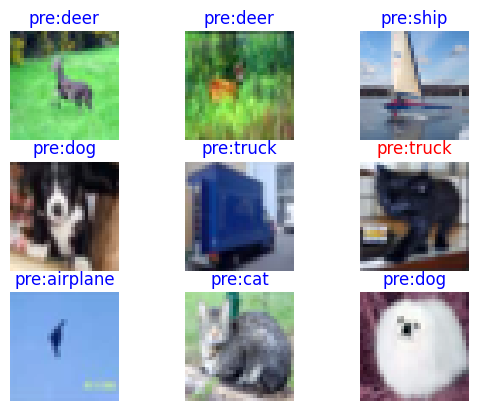

In [8]:
visualize_model('85.1.ckpt', ds_eval)

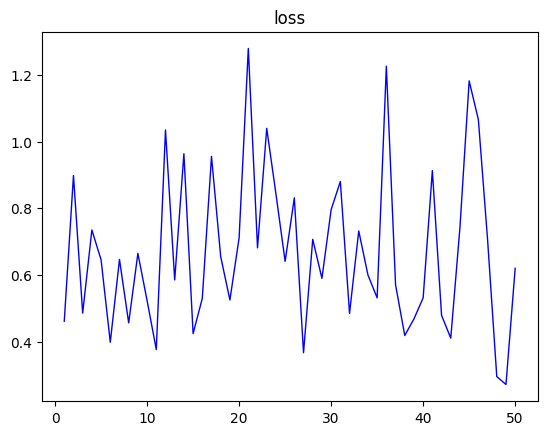

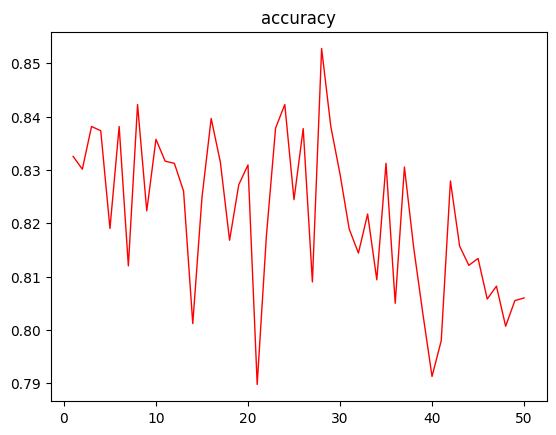

In [10]:
loss_ = []
for i in range(len(loss_show)):
    loss_.append(float(loss_show[i]))
x = np.arange(0, 50)+1
plt.plot(x, loss_,"b",linewidth=1)
plt.title('loss')
plt.show()
plt.plot(x, accuracy_show,"r",linewidth=1)
plt.title('accuracy')
plt.show()